Objective
------------------------
 Try out different hypothesis to investigate the effect of lockdown measures on mobility


- Assume that mobility is affected by weather, lockdown and miscellanous
- Consider misc. info to be one such as week info (if it is a holisday week etc...)
- Assume mobility follows a weekly pattern (people tend to spend less time in parks Mo-Fr for example). Exploit assumptions about human routines here
- Consider every day independent of one another

Methodology
----------------------------------

Consider

- Derive features for weather (initially consider simply the medan temperature)
- Lockdown index (some number)
- Mobility value
- is_weekend


# Data Sources

In order to run the cells the data has to be downloaded manually from these sources. Special thanks to the following sources for providing an open source license to access the data.

* Apple mobility data: https://covid19.apple.com/mobility
* Oxford stringency: https://github.com/OxCGRT/covid-policy-tracker
* Weather forecast from Yr, delivered by the Norwegian Meteorological Institute and NRK: https://api.met.no/weatherapi/locationforecast/2.0/
* Historical weather data from https://mesonet.agron.iastate.edu/ASOS/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from ipywidgets import Dropdown,IntSlider
from IPython.display import display
import os
%matplotlib inline
from functools import reduce

try:
    import graphviz
except:
    !pip install graphviz
    import graphviz
try:
    import pydotplus
except:
    !pip install pydotplus
    
from IPython.display import display
import networkx as nx
try:
    import pydot
except:
    !pip install pydot

try:
    from dowhy import CausalModel
except:
    #!pip install sympy
    !pip install -I dowhy
    from dowhy import CausalModel


Hypothesis I
------------------

Consider daily data for Berlin

Weather: historical air temperature

Mobility: Apple (Transit)

Stringency: OXCGRT

In [2]:
from project_lib import Project
project = Project.access()
Oxford_Stringency_Index_credentials = project.get_connected_data(name="Oxford Stringency Index")

import dsx_core_utils, os, io
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy

sqla_url= "db2+ibm_db://" + Oxford_Stringency_Index_credentials['username']+ ':' + Oxford_Stringency_Index_credentials['password'] + "@"+ Oxford_Stringency_Index_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
engine = create_engine(sqla_url, pool_size=10, max_overflow=20)
conn = engine.connect()

In [ ]:
# @hidden_cell
# The following code contains the credentials for a connection in your Project.
# You might want to remove those credentials before you share your notebook.
from project_lib import Project
project = Project.access()
Apple_transit_mobility_credentials = project.get_connected_data(name="Apple Transit Mobility")

apple_sqla_url= "db2+ibm_db://" + Apple_transit_mobility_credentials['username']+ ':' + Apple_transit_mobility_credentials['password'] + "@"+ Apple_transit_mobility_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
apple_engine = create_engine(apple_sqla_url, pool_size=10, max_overflow=20)
apple_conn = apple_engine.connect()

app_mob_df = pd.read_sql_table(Apple_transit_mobility_credentials['datapath'].split("/")[-1].lower(), apple_conn,index_col=['Timestamp'])
be_app_trans_df = app_mob_df[app_mob_df.region=='Berlin']
be_app_trans_df.drop(columns=['region'],inplace=True)

In [ ]:
ox_df = pd.read_sql_table("oxford_stringency_index", conn)
#ox_df.rename({'datetime_date':'date'},axis=1,inplace=True)

In [5]:
# Stringency Germany
#ox_df = pd.read_csv("/project_data/data_asset/sun/oxcgrt/OxCGRT_latest.csv")
ox_df["date"] = pd.to_datetime(ox_df["date"],format="%Y%m%d")

be_ox_df = ox_df[ox_df.countrycode=="DEU"]
be_ox_df.index= be_ox_df['date']
be_ox_df = be_ox_df[['stringencyindex']]
be_ox_df.rename({'stringencyindex':'lockdown'},axis=1,inplace=True)

# Max temperature
be_weather_df = pd.read_csv("/project_data/data_asset/mercury/weather/berlin_historical_weather.csv",index_col=[0])
be_weather_df.index = pd.to_datetime(be_weather_df.index)

In [6]:
dfs = [be_ox_df,be_app_trans_df,be_weather_df]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs)

df_final['is_weekend'] = np.where((df_final.index.weekday == 5)|(df_final.index.weekday == 6),1,0)

#df_final.rename({'stringencyindex':'lockdown'},axis=1,inplace=True)
#df_final.to_csv('/project_data/data_asset/mercury/germany_daily_asset_with_other_weather_params.csv')

In [7]:
df_final.head()

,lockdown,mobility,air_temperature,dew_point,relative_humidity,wind_speed,is_weekend
2020-01-13,0.0,100.00,6.0,4.0,86.89,3.598672,0
2020-01-14,0.0,104.84,9.0,3.0,66.27,5.398008,0
2020-01-15,0.0,104.32,10.5,3.5,61.52,5.655056,0
2020-01-16,0.0,109.63,7.0,3.5,81.07,3.084576,0
2020-01-17,0.0,119.85,5.0,2.0,81.00,4.112768,0


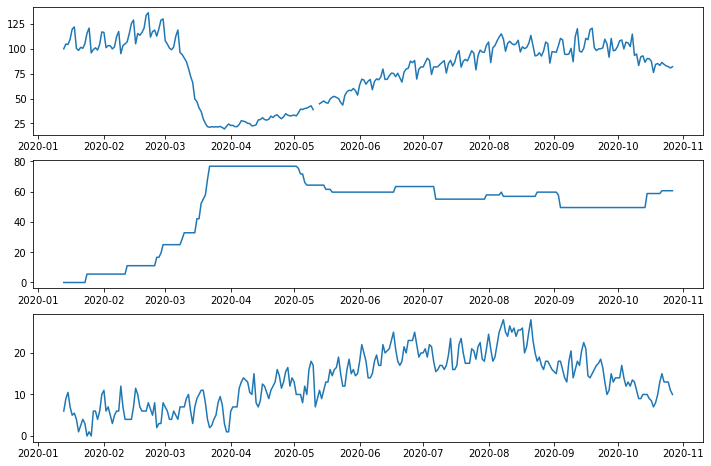

In [8]:
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axs[0].plot(df_final['mobility'])
axs[1].plot(df_final['lockdown'])
axs[2].plot(df_final['air_temperature'])

Why do I think day information is good? Looking at the graph above, it suggests that there is a strong periodic component in the mobility info. 
Let me plot the Power Spectral Density and check if there is any kind of periodicity in the data.

<StemContainer object of 3 artists>

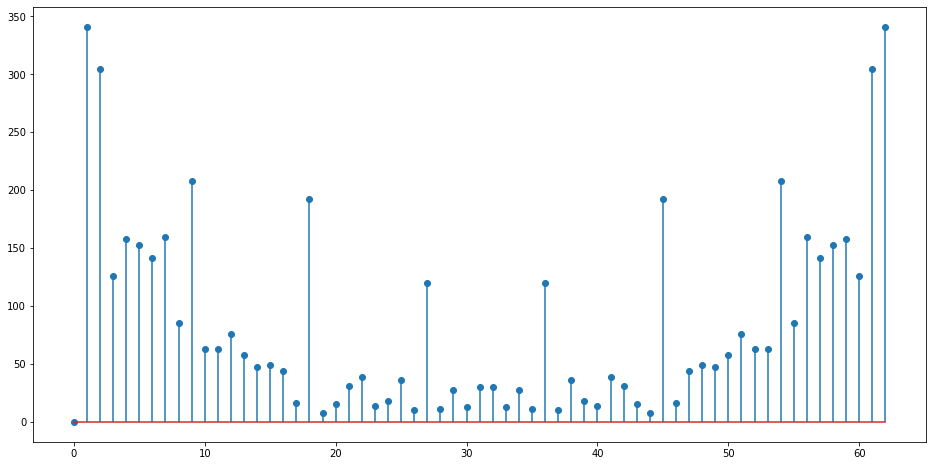

In [9]:
plt.figure(figsize=(16,8))
plt.stem(np.abs(np.fft.fft(df_final[df_final.index<=pd.to_datetime('2020-03-15')]['mobility'].values-np.mean(df_final[df_final.index<=pd.to_datetime('2020-03-15')]['mobility'].values))))

Let me consider week of the day as a feature for Causal Inference. Add it as a column in the datasource.

In [10]:
df_final.dropna()

,lockdown,mobility,air_temperature,dew_point,relative_humidity,wind_speed,is_weekend
2020-01-13,0.00,100.00,6.0,4.0,86.890,3.598672,0
2020-01-14,0.00,104.84,9.0,3.0,66.270,5.398008,0
2020-01-15,0.00,104.32,10.5,3.5,61.520,5.655056,0
2020-01-16,0.00,109.63,7.0,3.5,81.070,3.084576,0
2020-01-17,0.00,119.85,5.0,2.0,81.000,4.112768,0
...,...,...,...,...,...,...,...
2020-10-23,60.65,84.38,13.0,12.0,93.600,1.542288,0
2020-10-24,60.65,82.87,13.0,11.0,81.870,3.598672,1
2020-10-25,60.65,82.06,13.0,9.0,76.580,4.112768,1
2020-10-26,60.65,80.74,11.0,10.0,87.560,2.056384,0


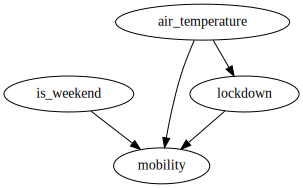

In [11]:
h1_causal_graph = nx.DiGraph()
h1_causal_graph.add_edge('is_weekend','mobility')
h1_causal_graph.add_edge('lockdown','mobility')
h1_causal_graph.add_edge('air_temperature','lockdown')
h1_causal_graph.add_edge('air_temperature','mobility')

graph_filename_h1='causal_mobility_weather_h1.dot'
nx.drawing.nx_pydot.write_dot(h1_causal_graph,graph_filename_h1)

with open(graph_filename_h1) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [12]:

h1_model = CausalModel(data=df_final.dropna(),treatment=['lockdown'],outcome='mobility',instruments=[],graph=graph_filename_h1,proceed_when_unidentifiable=True)
print(h1_model)

h1_estimand = h1_model.identify_effect()
print(h1_estimand)

h1_estimate = h1_model.estimate_effect(h1_estimand,method_name='backdoor.linear_regression',test_significance=True)
print(h1_estimate)

ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|is_weekend,air_temperature))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,is_weekend,air_temperature,U) = P(mobility|lockdown,is_weekend,air_temperature)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!



INFO:dowhy.causal_estimator:b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

## Realized estimand
b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
Target units: ate

## Estimate
Mean value: -1.304975722206592
p-value: [2.76427496e-64]
### Conditional Estimates
__categorical__is_weekend
(-0.001, 1.0]   -1.304976
dtype: float64


/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/dowhy/causal_estimator.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_quantiles, duplicates="drop")


Validate the causal effect estimate

In [13]:
h1_ref1 = h1_model.refute_estimate(estimand=h1_estimand, estimate=h1_estimate,method_name='placebo_treatment_refuter')
print(h1_ref1)

h1_ref2 = h1_model.refute_estimate(estimand=h1_estimand, estimate=h1_estimate,method_name='random_common_cause')
print(h1_ref2)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zer

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~plac

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Line

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

Refute: Use a Placebo Treatment
Estimated effect:-1.304975722206592
New effect:2.842170943040401e-14
p value:0.0

Refute: Add a Random Common Cause
Estimated effect:-1.304975722206592
New effect:-1.3067254038713543



Hypothesis II
------------------

Using google mobility instead of Apple transit mobility

Consider daily data for Berlin

Weather: historical air temperature 

Mobility: Google mobility data - transit station

Stringency: OXCGRT data

In [14]:

# @hidden_cell
# The following code contains the credentials for a connection in your Project.
# You might want to remove those credentials before you share your notebook.
Google_mobility_credentials = project.get_connected_data(name="Google mobility")


2020-12-17 14:57:54,838 - __PROJECT_LIB__ - INFO - AssetsAPIProxy__search_assets(): sending request to fetch assets.
INFO:__PROJECT_LIB__:AssetsAPIProxy__search_assets(): sending request to fetch assets.
2020-12-17 14:57:54,840 - __PROJECT_LIB__ - INFO - proxyUtils: POST, url: https://internal-nginx-svc:12443/v2/asset_types/data_asset/search?project_id=6fd25d50-69b5-4c66-9564-2a81f7b513b5
INFO:__PROJECT_LIB__:proxyUtils: POST, url: https://internal-nginx-svc:12443/v2/asset_types/data_asset/search?project_id=6fd25d50-69b5-4c66-9564-2a81f7b513b5
2020-12-17 14:57:54,994 - __PROJECT_LIB__ - INFO - AssetsAPIProxy__fetch_asset(): sending request to fetch asset.
INFO:__PROJECT_LIB__:AssetsAPIProxy__fetch_asset(): sending request to fetch asset.
2020-12-17 14:57:54,996 - __PROJECT_LIB__ - INFO - proxyUtils: GET, url: https://internal-nginx-svc:12443/v2/assets/4b145c81-6f24-4b3a-b947-7676e59f8ef2?project_id=6fd25d50-69b5-4c66-9564-2a81f7b513b5
INFO:__PROJECT_LIB__:proxyUtils: GET, url: https://

In [15]:
Google_mobility_df = pd.read_sql_table(Google_mobility_credentials['datapath'].split("/")[-1].lower(),conn)

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/sqlalchemy/engine/reflection.py:884: SAWarning: index key 'sqlnotapplicable' was not located in columns for table 'google_mobility'
  "columns for table '%s'" % (flavor, c, table_name)


In [18]:
be_google_mobility_df = Google_mobility_df[Google_mobility_df.sub_region_1=="Berlin"][['transit_stations_percent_change_from_baseline']]
be_google_mobility_df.index = pd.to_datetime(Google_mobility_df[Google_mobility_df.sub_region_1=="Berlin"]['date'])

In [19]:
dfs2 = [be_ox_df,be_google_mobility_df,be_weather_df]
df_final2 = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs2)
df_final2.rename({'transit_stations_percent_change_from_baseline':'mobility','StringencyIndex':'lockdown'},axis=1,inplace=True)

df_final2['is_weekend'] = np.where((df_final2.index.weekday == 5)|(df_final2.index.weekday == 6),1,0)

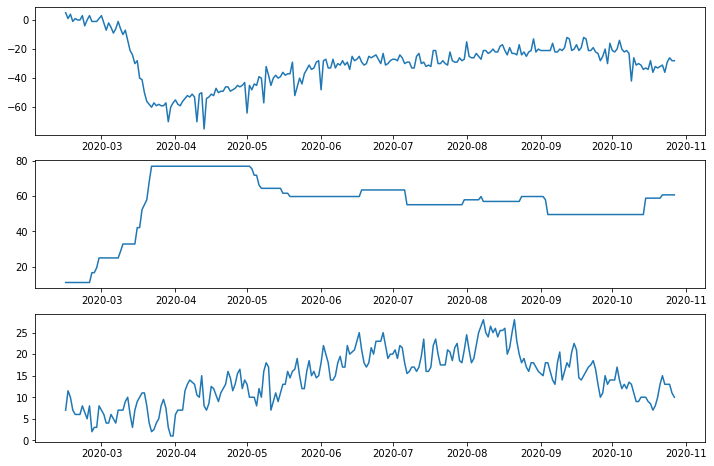

In [20]:
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axs[0].plot(df_final2['mobility'])
axs[1].plot(df_final2['lockdown'])
axs[2].plot(df_final2['air_temperature'])

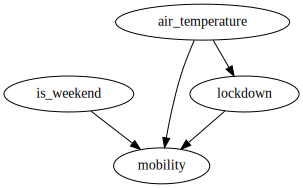

In [21]:
h2_causal_graph = nx.DiGraph()
h2_causal_graph.add_edge('is_weekend','mobility')
h2_causal_graph.add_edge('lockdown','mobility')
h2_causal_graph.add_edge('air_temperature','lockdown')
h2_causal_graph.add_edge('air_temperature','mobility')

graph_filename_h2='causal_mobility_weather_h2.dot'
nx.drawing.nx_pydot.write_dot(h2_causal_graph,graph_filename_h2)

with open(graph_filename_h2) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [22]:
h2_model = CausalModel(data=df_final2.dropna(),treatment=['lockdown'],outcome='mobility',instruments=[],graph=graph_filename_h2,proceed_when_unidentifiable=True)
print(h2_model)

h2_estimand = h2_model.identify_effect()
print(h2_estimand)

h2_estimate = h2_model.estimate_effect(h2_estimand,method_name='backdoor.linear_regression',test_significance=True)
print(h2_estimate)

ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|is_weekend,air_temperature))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,is_weekend,air_temperature,U) = P(mobility|lockdown,is_weekend,air_temperature)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Id

In [23]:
h2_ref1 = h2_model.refute_estimate(estimand=h2_estimand, estimate=h2_estimate,method_name='placebo_treatment_refuter')
print(h2_ref1)

h2_ref2 = h2_model.refute_estimate(estimand=h2_estimand, estimate=h2_estimate,method_name='random_common_cause')
print(h2_ref2)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zer

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~plac

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Line

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

Refute: Use a Placebo Treatment
Estimated effect:-0.916286445471254
New effect:0.0
p value:1.0

Refute: Add a Random Common Cause
Estimated effect:-0.916286445471254
New effect:-0.9153701997540509



**Remark**

As Google data is available only from mid Feb whereas Apple mobility data is available since mid Jan. So, we use Apple mobility data

Hypothesis III
------------------

Consider daily data for Berlin

Weather: historical air temperature 

Mobility: Apple (Transit)

Stringency: OXCGRT Clustering data

In [ ]:

# @hidden_cell
# The following code contains the credentials for a connection in your Project.
# You might want to remove those credentials before you share your notebook.

from project_lib import Project
project = Project.access()
Emergent_DB2_Warehouse_credentials = project.get_connection(name="db2 Warehouse ealuser")


In [25]:
import dsx_core_utils, os, io
import pandas as pd
from sqlalchemy import create_engine
import sqlalchemy

sqla_url= "db2+ibm_db://" + Emergent_DB2_Warehouse_credentials['username']+ ':' + Emergent_DB2_Warehouse_credentials['password'] + "@"+ Emergent_DB2_Warehouse_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
engine = create_engine(sqla_url, pool_size=10, max_overflow=20)

In [26]:
stringency_clustering_df = pd.read_sql_query('SELECT * FROM "EALUSER"."STRINGENCY_INDEX_CLUSTERING"',engine)

In [27]:
be_stringency_clustering_df = stringency_clustering_df[stringency_clustering_df.country=="Germany"]
be_stringency_clustering_df.index = pd.to_datetime(be_stringency_clustering_df['state_date'])
be_stringency_clustering_df = be_stringency_clustering_df.rename({'state_value':'lockdown'},axis=1)[['lockdown']]

In [28]:
dfs3 = [be_stringency_clustering_df,be_app_trans_df,be_weather_df]
df_final3 = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs3)
df_final3.rename({'change':'mobility'},axis=1,inplace=True)

df_final3['is_weekend'] = np.where((df_final3.index.weekday == 5)|(df_final3.index.weekday == 6),1,0)
#df_final.to_csv('/project_data/data_asset/mercury/germany_daily_asset_with_other_weather_params.csv')

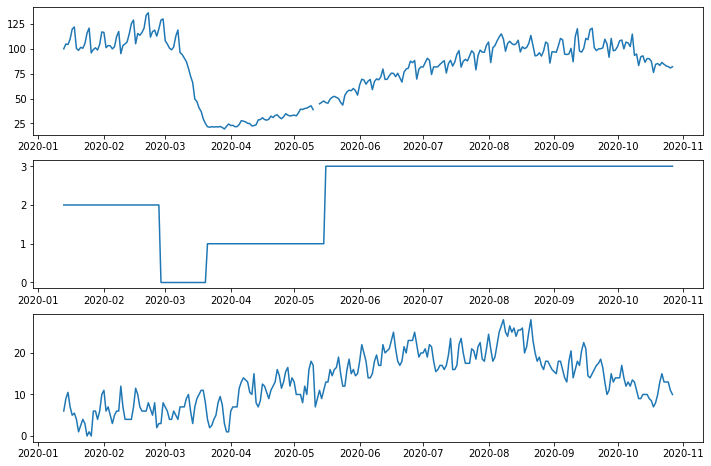

In [29]:
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axs[0].plot(df_final3['mobility'])
axs[1].plot(df_final3['lockdown'])
axs[2].plot(df_final3['air_temperature'])

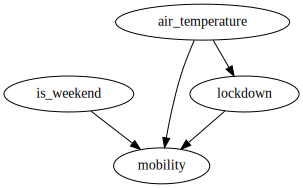

In [30]:
h3_causal_graph = nx.DiGraph()
h3_causal_graph.add_edge('is_weekend','mobility')
h3_causal_graph.add_edge('lockdown','mobility')
h3_causal_graph.add_edge('air_temperature','lockdown')
h3_causal_graph.add_edge('air_temperature','mobility')

graph_filename_h3='causal_mobility_weather_h3.dot'
nx.drawing.nx_pydot.write_dot(h3_causal_graph,graph_filename_h3)

with open(graph_filename_h3) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [31]:
h3_model = CausalModel(data=df_final3.dropna(),treatment=['lockdown'],outcome='mobility',instruments=[],graph=graph_filename_h3,proceed_when_unidentifiable=True)
print(h3_model)

h3_estimand = h3_model.identify_effect()
print(h3_estimand)

h3_estimate = h3_model.estimate_effect(h3_estimand,method_name='backdoor.linear_regression',test_significance=True)
print(h3_estimate)

ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|is_weekend,air_temperature))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,is_weekend,air_temperature,U) = P(mobility|lockdown,is_weekend,air_temperature)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Id

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/dowhy/causal_estimator.py:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_quantiles, duplicates="drop")


In [32]:
h3_ref1 = h3_model.refute_estimate(estimand=h3_estimand, estimate=h3_estimate,method_name='placebo_treatment_refuter')
print(h3_ref1)

h3_ref2 = h3_model.refute_estimate(estimand=h3_estimand, estimate=h3_estimate,method_name='random_common_cause')
print(h3_ref2)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.ca

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.ca

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Discrete Uniform Distribution lying between 0 and 3
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.ca

Refute: Use a Placebo Treatment
Estimated effect:18.486716089811118
New effect:0.11778866383502759
p value:0.43

Refute: Add a Random Common Cause
Estimated effect:18.486716089811118
New effect:18.48512858462611



**Remark**

The Causal estimate has a really low p value when we use the stringency clustering data. So, we can also replace the raw Oxford stringency data with the stringency clustering data


Hypothesis IV
------------------

Consider daily data for Berlin

Weather: historical air temperature 

Mobility: Waze mobility data - Source: https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/waze_reports/Waze_City-Level_Data.csv

Stringency: OXCGRT data

In [33]:
waze_df = pd.read_csv("https://raw.githubusercontent.com/ActiveConclusion/COVID19_mobility/master/waze_reports/Waze_City-Level_Data.csv")
waze_df['Date'] = pd.to_datetime(waze_df['Date'])

be_waze_df = waze_df[waze_df.City=="Berlin"]
be_waze_df.index = be_waze_df['Date']
be_waze_df = be_waze_df[['% Change In Waze Driven Miles/KMs']]
be_waze_df.columns = ['mobility']

In [34]:
dfs4 = [be_ox_df,be_waze_df,be_weather_df]
df_final4 = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs4)

df_final4['is_weekend'] = np.where((df_final4.index.weekday == 5)|(df_final4.index.weekday == 6),1,0)
#df_final4.rename({'StringencyIndex':'lockdown'},axis=1,inplace=True)


In [35]:
df_final4

,lockdown,mobility,air_temperature,dew_point,relative_humidity,wind_speed,is_weekend
2020-03-01,25.00,-0.06,7.0,2.0,70.480,5.140960,1
2020-03-02,25.00,-0.38,6.0,3.0,81.200,3.598672,0
2020-03-03,25.00,-0.13,4.0,2.0,86.840,2.570480,0
2020-03-04,25.00,-0.13,4.0,1.0,80.790,3.084576,0
2020-03-05,25.00,-0.13,6.0,0.0,65.380,3.598672,0
...,...,...,...,...,...,...,...
2020-10-23,60.65,0.07,13.0,12.0,93.600,1.542288,0
2020-10-24,60.65,-0.66,13.0,11.0,81.870,3.598672,1
2020-10-25,60.65,0.04,13.0,9.0,76.580,4.112768,1
2020-10-26,60.65,-0.01,11.0,10.0,87.560,2.056384,0


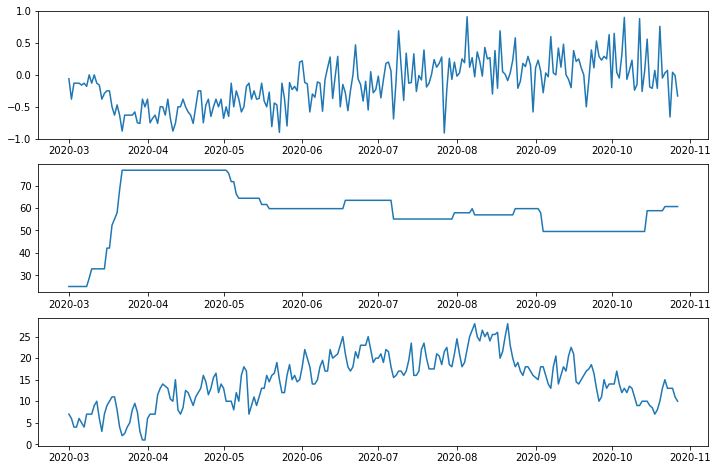

In [36]:
fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
axs[0].plot(df_final4['mobility'])
axs[1].plot(df_final4['lockdown'])
axs[2].plot(df_final4['air_temperature'])

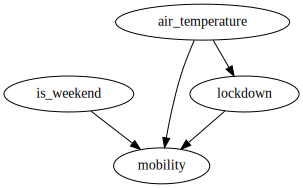

In [37]:
h4_causal_graph = nx.DiGraph()
h4_causal_graph.add_edge('is_weekend','mobility')
h4_causal_graph.add_edge('lockdown','mobility')
h4_causal_graph.add_edge('air_temperature','lockdown')
h4_causal_graph.add_edge('air_temperature','mobility')

graph_filename_h4='causal_mobility_weather_h4.dot'
nx.drawing.nx_pydot.write_dot(h4_causal_graph,graph_filename_h4)

with open(graph_filename_h4) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [38]:
h4_model = CausalModel(data=df_final4.dropna(),treatment=['lockdown'],outcome='mobility',instruments=[],graph=graph_filename_h4,proceed_when_unidentifiable=True)
print(h4_model)

h4_estimand = h4_model.identify_effect()
print(h4_estimand)

h4_estimate = h4_model.estimate_effect(h4_estimand,method_name='backdoor.linear_regression',test_significance=True)
print(h4_estimate)

ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|is_weekend,air_temperature))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,is_weekend,air_temperature,U) = P(mobility|lockdown,is_weekend,air_temperature)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Id

In [45]:
h4_ref1 = h4_model.refute_estimate(estimand=h4_estimand, estimate=h4_estimate,method_name='placebo_treatment_refuter')
print(h4_ref1)

h4_ref2 = h4_model.refute_estimate(estimand=h4_estimand, estimate=h4_estimate,method_name='random_common_cause')
print(h4_ref2)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_

INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0


INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend


INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend


INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+lockdown_1+is_weekend+mobility_1+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Making use of Bootstrap as we have more than 100 examples.
                 Note: The greater the number of examples, the more accurate are the confidence estimates
INFO:dowhy.causal_estimator:b: mobility~lockdown+lockdown_1+is_weekend+mobility_1+air_temperature+w_random+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Use a Placebo Treatment
Estimated effect:-0.0026565607671270516
New effect:4.218847493575595e-15
p value:0.0

Refute: Add a Random Common Cause
Estimated effect:-0.0026565607671270516
New effect:-0.003101377665457393



**Comments**

As the data corresponds to only driving data, the plot shows that it is not really affected by the lockdown measures. Moreover, the driving mobility data is available only from 01.03.2020

Hypothesis V
------------------

Consider daily data for other cities/country such as London, New york and Singapore

Weather: historical air temperature 

Mobility: Apple mobility (transit)

Stringency: OXCGRT data

1. London - EGLL, GBR
2. New York - NYC, USA
3. Singapore - WSAP, SGP

In [ ]:
app_df = pd.read_csv("/project_data/data_asset/sun/apple_mobility/applemobilitytrends-2020-10-14.csv")

In [42]:
def region_specific_data(mobility_region,weather_station,stringency_country_code):

    cs_app_trans_df = app_df[(app_df.region==mobility_region)&
                           (app_df.transportation_type=="transit")].drop(['geo_type','region','transportation_type',
                                                                          'alternative_name','sub-region','country'],axis=1).transpose()
    cs_app_trans_df.columns= ['mobility']

    # Stringency Germany

    if stringency_country_code == "GBR":
        # Consider only England
        cs_ox_df = ox_df[ox_df.regionname=="England"]
        cs_ox_df.index= cs_ox_df['date']
        cs_ox_df = cs_ox_df[['stringencyindex']]
        
    elif stringency_country_code == "USA":
        # Consider only New York
        cs_ox_df = ox_df[ox_df.regionname=="New York"]
        cs_ox_df.index= cs_ox_df['date']
        cs_ox_df = cs_ox_df[['stringencyindex']]
    else:
        cs_ox_df = ox_df[ox_df.countrycode==stringency_country_code]
        cs_ox_df.index= cs_ox_df['date']
        cs_ox_df = cs_ox_df[['stringencyindex']]

    # Max temperature

    historical_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station={}&data=tmpc&year1=2020&month1=1&day1=1&year2=2020&month2=10&day2=28&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2".format(weather_station)
    hist_weather_df = pd.read_csv(historical_url)

    # Replace missing and trace as na
    hist_weather_df.replace("M",np.nan,inplace=True)
    hist_weather_df.replace("M",np.nan,inplace=True)

    #Convert to float
    hist_weather_df['tmpc'] = hist_weather_df['tmpc'].astype(np.float64)
    hist_weather_df['valid'] = pd.to_datetime(hist_weather_df['valid'])

    hist_weather_df.rename({'valid':'time','tmpc':'air_temperature'},axis=1, inplace=True)

    hist_weather_df.index = hist_weather_df['time']
    hist_weather_df = hist_weather_df.resample("1D").median()

    dfs = [cs_ox_df,cs_app_trans_df,hist_weather_df]
    df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs)
    df_final.rename({'stringencyindex':'lockdown'},axis=1,inplace=True)
    df_final['is_weekend'] = np.where((df_final.index.weekday == 5)|(df_final.index.weekday == 6),1,0)
    
    #return df_final

    fig,axs = plt.subplots(nrows=3,ncols=1,figsize=(12,8))
    axs[0].plot(df_final['mobility'])
    axs[1].plot(df_final['lockdown'])
    axs[2].plot(df_final['air_temperature'])
    fig.suptitle(mobility_region)
    plt.show()
    
    causal_graph = nx.DiGraph()
    causal_graph.add_edge('is_weekend','mobility')
    causal_graph.add_edge('lockdown','mobility')
    causal_graph.add_edge('air_temperature','lockdown')
    causal_graph.add_edge('air_temperature','mobility')

    graph_filename_='causal_mobility_weather_.dot'
    nx.drawing.nx_pydot.write_dot(causal_graph,graph_filename_)

    with open(graph_filename_) as f:
        dot_graph = f.read()
    graphviz.Source(dot_graph)
    
    _model = CausalModel(data=df_final.dropna(),treatment=['lockdown'],outcome='mobility',instruments=[],graph=graph_filename_,proceed_when_unidentifiable=True)
    print(_model)

    _estimand = _model.identify_effect()
    print(_estimand)

    _estimate = _model.estimate_effect(_estimand,method_name='backdoor.linear_regression',test_significance=True)
    print(_estimate)
    
    _ref1 = _model.refute_estimate(estimand=_estimand, estimate=_estimate,method_name='placebo_treatment_refuter')
    print(_ref1)

    _ref2 = _model.refute_estimate(estimand=_estimand, estimate=_estimate,method_name='random_common_cause')
    print(_ref2)
    
    return 1

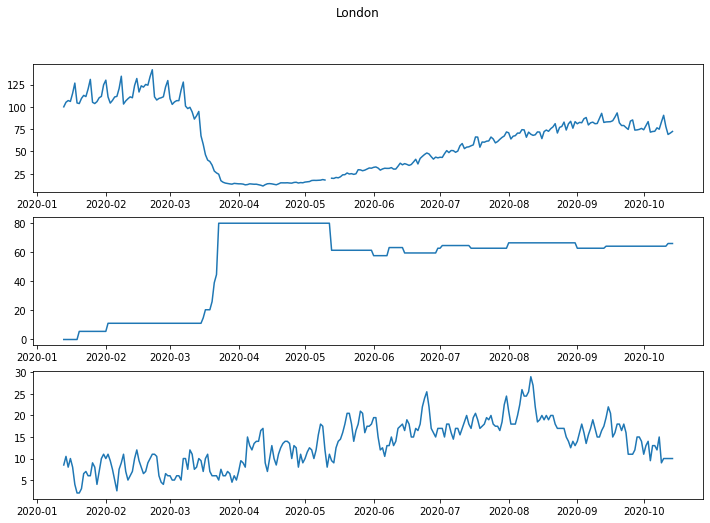

ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/dowhy/causal_estimator.py:228: SettingWithCopyWarning: 
A value is trying to be set on a c

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|is_weekend,air_temperature))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,is_weekend,air_temperature,U) = P(mobility|lockdown,is_weekend,air_temperature)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Id

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~plac

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Line

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~plac

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Line

Refute: Use a Placebo Treatment
Estimated effect:-1.24403787857797
New effect:0.0
p value:1.0

Refute: Add a Random Common Cause
Estimated effect:-1.24403787857797
New effect:-1.2454754546726576



In [43]:
region_specific_data('London','EGLL', 'GBR')

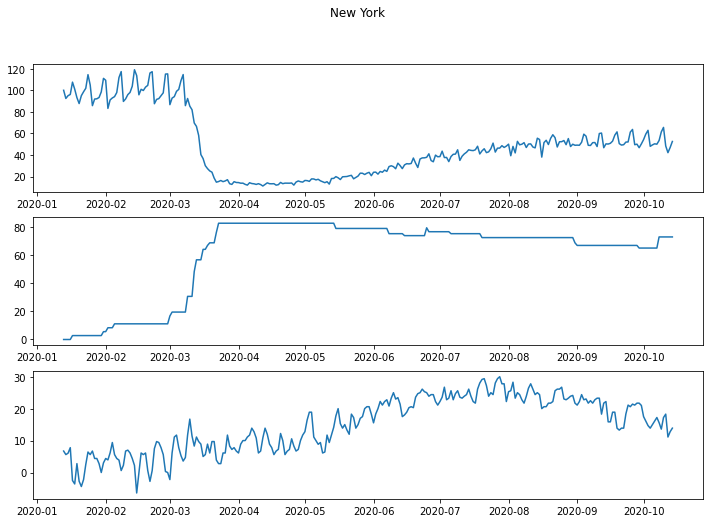

ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|is_weekend,air_temperature))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,is_weekend,air_temperature,U) = P(mobility|lockdown,is_weekend,air_temperature)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Id

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~plac

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Line

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

Refute: Use a Placebo Treatment
Estimated effect:-1.2127103680309546
New effect:2.5579538487363607e-13
p value:0.0

Refute: Add a Random Common Cause
Estimated effect:-1.2127103680309546
New effect:-1.212385330476721



In [44]:
region_specific_data('New York','NYC', 'USA')

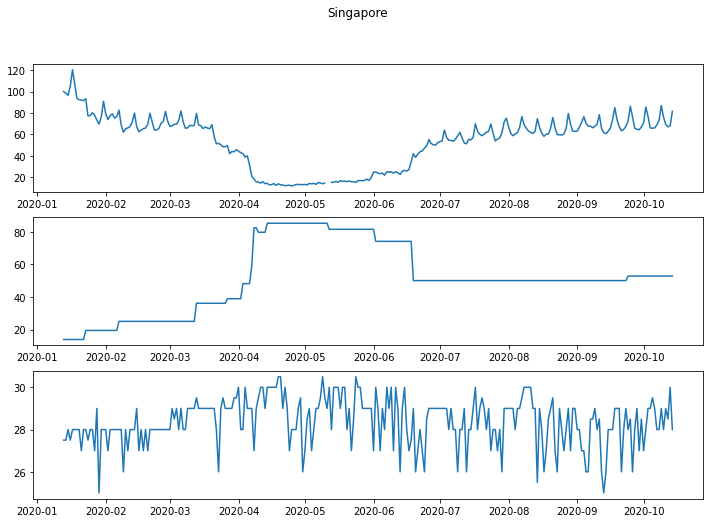

ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['lockdown'] on outcome ['mobility']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: mobility~lockdown+is_weekend+air_temperature+lockdown*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/dowhy/causal_estimator.py:228: SettingWithCopyWarning: 
A value is trying to be set on a c

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
     d                                                       
───────────(Expectation(mobility|is_weekend,air_temperature))
d[lockdown]                                                  
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,is_weekend,air_temperature,U) = P(mobility|lockdown,is_weekend,air_temperature)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
     d                                            
───────────(Expectation(mobility|air_temperature))
d[lockdown]                                       
Estimand assumption 1, Unconfoundedness: If U→{lockdown} and U→mobility then P(mobility|lockdown,air_temperature,U) = P(mobility|lockdown,air_temperature)

### Estimand : 3
Estimand name: iv
No such variable found!

### Estimand : 4
Estimand name: frontdoor
No such variable found!

*** Causal Estimate ***

## Id

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~plac

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Line

/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: mobility~placebo+is_weekend+air_temperature+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
/opt/conda/envs/Python-3.6-WMLCE/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
INFO:dowhy.causal_refuters.placebo_treatment

Refute: Use a Placebo Treatment
Estimated effect:-0.989717859962667
New effect:7.105427357601002e-15
p value:0.0

Refute: Add a Random Common Cause
Estimated effect:-0.989717859962667
New effect:-0.9892500275299341



In [45]:
region_specific_data('Singapore','WSAP', 'SGP')

**Comments**

* For all three cities the estimator parameters given by the dowhy model are the same: "mobility ~ lockdown+is_weekend+air_temperature+lockdown*is_weekend"


**Author**

* Shri Nishanth Rajendran - AI Development Specialist, R² Data Labs, Rolls Royce


Special thanks to Deepak Srinivasan and Alvaro Corrales Cano